In [1]:
import numpy as np
import pandas as pd 
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import bambi as bmb
import arviz as az 
import pymc as pm 
import os, ast, itertools
import networkx as nx
from sklearn.cluster import KMeans
import scipy
from sklearn.manifold import MDS



In [2]:
walk_500_ids = pd.read_csv('demographics/prolific_export_walk500.csv')['Participant id']
walk_3_ids = pd.read_csv('demographics/prolific_export_walk3.csv')['Participant id']
walk_500_mem_ids = pd.read_csv('demographics/prolific_export_walk500_mem.csv')['Participant id']



In [4]:
def extract_similarity(filename):
    if filename.endswith('gz'):
        return None
    data = pd.read_csv('data/'+filename)
    if len(data) < 740:
        print(filename)
        return None
    # print(data)
    # try:
    data_similarity = data[data['stimulus_pair_chosen'].notna()].reset_index(drop=True)[['similarity_slider.response', 'similarity_slider_2.response', 'stimulus_pair_chosen']]

    data_similarity.loc[data_similarity['similarity_slider.response'].notna(), 'exposure_stage'] = 'pre'
    data_similarity.loc[data_similarity['similarity_slider_2.response'].notna(), 'exposure_stage'] = 'post'

    data_similarity.loc[data_similarity['similarity_slider.response'].notna(), 'similarity_rating'] = data_similarity[data_similarity['similarity_slider.response'].notna()]['similarity_slider.response'].values
    data_similarity.loc[data_similarity['similarity_slider_2.response'].notna(), 'similarity_rating'] = data_similarity[data_similarity['similarity_slider_2.response'].notna()]['similarity_slider_2.response'].values
    data_similarity['participant'] = data['Prolific ID']

    ### Code to extract stimuli ids from path_ids
    path_stimuli = data.loc[data['stimulus_chosen'].notna(), 'stimulus_chosen'].values
    path_id = data.loc[data['path_id'].notna(), 'path_id'].values


    path_dict = {i:j for (j, i) in zip(path_id.astype(int), path_stimuli)}
    path_id_pair = np.array([np.array([path_dict[ast.literal_eval(i)[0]], path_dict[ast.literal_eval(i)[1]]]) for i in data_similarity['stimulus_pair_chosen']])

    data_similarity['path_id_0'] = path_id_pair[:, 0]
    data_similarity['path_id_1'] = path_id_pair[:, 1]
    # data_similarity['path_id']
    # print(data_similarity)
    # except:
        # return None
    # print(data['Prolific ID'].unique()[0])
    # print(walk_500_ids)
    if data['Prolific ID'].unique()[0] in walk_500_ids.values:
        data_similarity['walk_length'] = 500
    elif data['Prolific ID'].unique()[0] in walk_3_ids.values:
        data_similarity['walk_length'] = 3
    else:
        data_similarity['walk_length'] = 5000

    return data_similarity[['participant', 'walk_length', 'stimulus_pair_chosen', 'exposure_stage', 'path_id_0', 'path_id_1', 'similarity_rating']]


In [55]:
def extract_nback_data(filename):
    if filename.endswith('gz'):
        return None
    data = pd.read_csv('data/'+filename)
    if len(data) < 740:
        print(filename)
        return None

    data = pd.read_csv(f'data/{filename}')

    # Drop rows with missing data in column: 'should_hit'
    data = data.dropna(subset=['should_hit'])
    # Drop columns: 'Consent.question1', 'Prolific ID' and 134 other columns
    data = data[['Prolific ID', 'Hit', 'should_hit']]
    # data = data.drop(columns=['Consent.question1', 'Age (Optional, in Years)', 'Gender (Optional, in Years)', 'browser', 'date', 'expName', 'psychopyVersion', 'OS', 'frameRate', 'instructions_0.started', 'instructions_0.stopped', 'instructions0_moveon.keys', 'instructions0_moveon.rt', 'instructions0_moveon.duration', 'instructions_1.started', 'instructions_1.stopped', 'instructions1_key_resp.keys', 'instructions1_key_resp.rt', 'instructions1_key_resp.duration', 'instructions_2.started', 'instructions_2.stopped', 'instructions2_key_resp.keys', 'instructions2_key_resp.rt', 'instructions2_key_resp.duration', 'eligibilityq1.started', 'eligibilityq1.stopped', 'radio_task.response', 'radio_task.rt', 'radio_similarity_compare.response', 'radio_similarity_compare.rt', 'instr_repeat.started', 'instr_repeat.stopped', 'instr_repeat_key_resp.keys', 'instr_repeat_key_resp.rt', 'instr_repeat_key_resp.duration', 'instr_repeat_loop.thisRepN', 'instr_repeat_loop.thisTrialN', 'instr_repeat_loop.thisN', 'instr_repeat_loop.thisIndex', 'instr_repeat_loop.ran', 'exp_start.started', 'exp_start.stopped', 'next_trial_button.started', 'next_trial_button.stopped', 'next_button.numClicks', 'next_button.timesOn', 'next_button.timesOff', 'trial.started', 'stimulus_pair_chosen', 'trial.stopped', 'similarity_slider.response', 'similarity_slider.rt', 'trials.thisRepN', 'trials.thisTrialN', 'trials.thisN', 'trials.thisIndex', 'trials.ran', 'n_back_instr_0.started', 'n_back_instr_0.stopped', 'n_back_instr_text_key_resp_0.keys', 'n_back_instr_text_key_resp_0.rt', 'n_back_instr_text_key_resp_0.duration', 'n_back_instr_05.started', 'n_back_instr_05.stopped', 'n_back_instr_text_key_resp_05.keys', 'n_back_instr_text_key_resp_05.rt', 'n_back_instr_text_key_resp_05.duration', 'n_back_instr_1.started', 'n_back_instr_1.stopped', 'n_back_instr_text_key_resp_1.keys', 'n_back_instr_text_key_resp_1.rt', 'n_back_instr_text_key_resp_1.duration', 'eligibilityq2.started', 'eligibilityq2.stopped', 'radio_nback_compare.response', 'radio_nback_compare.rt', 'radio_nback_key.response', 'radio_nback_key.rt', 'nback_instr_repeat.started', 'nback_instr_repeat.stopped', 'nback_instr_repeat_key_resp.keys', 'nback_instr_repeat_key_resp.rt', 'nback_instr_repeat_key_resp.duration', 'nback_correct_elig_loop.thisRepN', 'nback_correct_elig_loop.thisTrialN', 'nback_correct_elig_loop.thisN', 'nback_correct_elig_loop.thisIndex', 'nback_correct_elig_loop.ran', 'nback_start.started', 'nback_start.stopped', 'fixation.started', 'fixation.stopped', 'n_back_stim_disp.started', 'stimulus_chosen', 'n_back_stim_disp.stopped', 'n_back_key_resp.keys', 'n_back_trials.thisRepN', 'n_back_trials.thisTrialN', 'n_back_trials.thisN', 'n_back_trials.thisIndex', 'n_back_trials.ran', 'nback_break.started', 'nback_break.stopped', 'nback_break_key_resp.keys', 'nback_break_key_resp.rt', 'nback_break_key_resp.duration', 'sim_instructions_1.started', 'sim_instructions_1.stopped', 'instructions1_key_resp_2.keys', 'instructions1_key_resp_2.rt', 'instructions1_key_resp_2.duration', 'sim_instructions_2.started', 'sim_instructions_2.stopped', 'instructions2_key_resp_2.keys', 'instructions2_key_resp_2.rt', 'instructions2_key_resp_2.duration', 'rep_sim_start.started', 'rep_sim_start.stopped', 'next_trial_button_sim.started', 'next_trial_button_sim.stopped', 'next_button_sim.numClicks', 'next_button_sim.timesOn', 'next_button_sim.timesOff', 'sim_trial.started', 'sim_trial.stopped', 'similarity_slider_2.response', 'similarity_slider_2.rt', 'sim_trials.thisRepN', 'sim_trials.thisTrialN', 'sim_trials.thisN', 'sim_trials.thisIndex', 'sim_trials.ran', 'temp_end.started', 'temp_end.stopped'])
    data['accuracy'] = data['should_hit'] == data['Hit']
    data['hit_rate'] = data['should_hit'] == data['accuracy']
    data['fa_rate'] = data['Hit'] != data['accuracy']
    return data.reset_index(drop=True)




In [7]:
data_files = os.listdir('data/')

In [47]:
similarity_data = pd.concat([extract_similarity(file) for file in data_files])

undefined_eb_07_2023-12-31_16h25.23.704.csv
undefined_eb_07_2023-12-31_16h38.14.263.csv


In [56]:
nback_data = pd.concat([extract_nback_data(file) for file in data_files])

undefined_eb_07_2023-12-31_16h25.23.704.csv
undefined_eb_07_2023-12-31_16h38.14.263.csv


In [57]:
nback_data_participant = nback_data.groupby(['Prolific ID']).mean().reset_index()
nback_data_participant

C:\Users\tejas\AppData\Local\Temp\ipykernel_23724\3080547061.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nback_data_participant = nback_data.groupby(['Prolific ID']).mean().reset_index()


,Prolific ID,accuracy,hit_rate,fa_rate
0,56d857ad4a9be1000a53af36,0.812877,0.144869,0.752515
1,57c2f3ed0c656b00019c5988,0.597586,0.338028,0.742455
2,58e98b8c41b9a700018d580b,0.788732,0.221328,0.740443
3,59a1ddac5dfd6b000152601f,0.645875,0.243461,0.772636
4,5a08c9a7f2e3460001edb063,0.766600,0.132797,0.726358
5,5a198755f2e3460001edc5c9,0.871227,0.000000,0.871227
6,5a3b209b2f3c2500018bc67d,0.822938,0.160966,0.758551
7,5b40ff8b3d066d0001609b63,0.746479,0.187123,0.764588
8,5ba855d47c0ebe0001272f70,0.774648,0.124748,0.766600
9,5c3820ee1ede2b0001155929,0.615694,0.305835,0.740443


In [10]:
walk_lengths = similarity_data.groupby(['participant']).mean().reset_index()[['walk_length']].values.reshape((-1))

C:\Users\tejas\AppData\Local\Temp\ipykernel_23724\1990947713.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  walk_lengths = similarity_data.groupby(['participant']).mean().reset_index()[['walk_length']].values.reshape((-1))


In [284]:
similarity_data['same_item_sim'] = False
similarity_data.loc[similarity_data['path_id_0'] == similarity_data['path_id_1'], 'same_item_sim'] = similarity_data.loc[similarity_data['path_id_0'] == similarity_data['path_id_1'], 'similarity_rating'] > 4

In [12]:
# similarity_data.loc[similarity_data['path_id_0'] == similarity_data['path_id_1']].groupby(['participant']).median()

In [13]:
num_participants = similarity_data['participant'].unique().shape[0]
participant_ids = similarity_data['participant'].unique()
similarity_matrix = np.zeros((num_participants, 2, 15, 15))

In [14]:
for i, p in enumerate(participant_ids):
    p_sim = similarity_data.loc[((similarity_data['participant'] == p) & (similarity_data['exposure_stage'] == 'pre'))]
    similarity_matrix[i, 0, p_sim['path_id_0'], p_sim['path_id_1']] = p_sim['similarity_rating']

    p_sim = similarity_data.loc[((similarity_data['participant'] == p) & (similarity_data['exposure_stage'] == 'post'))]
    similarity_matrix[i, 1, p_sim['path_id_0'], p_sim['path_id_1']] = p_sim['similarity_rating']


In [15]:
for p in range(num_participants):
    for s in range(2):    
        for (i, j) in itertools.product(np.arange(15), np.arange(15)):
            if similarity_matrix[p, s, i, j] == 0:
                similarity_matrix[p, s, i, j] =  similarity_matrix[p, s, j, i]


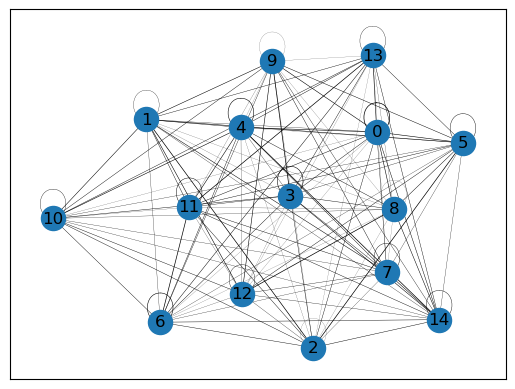

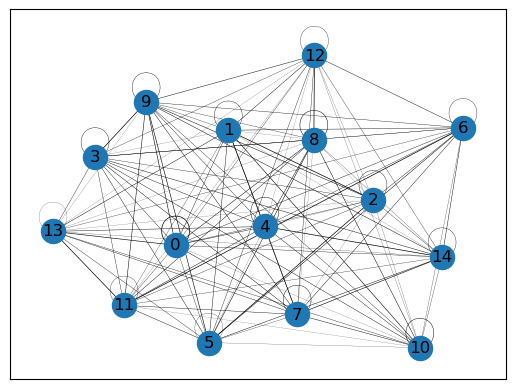

In [53]:
p_id = 22
G = nx.from_numpy_array(similarity_matrix[p_id][0])
nx.draw_networkx(G, width = np.ravel(similarity_matrix[p_id][0])/10)
plt.show()
nx.draw_networkx(G, width = np.ravel(similarity_matrix[p_id][1])/10)


c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


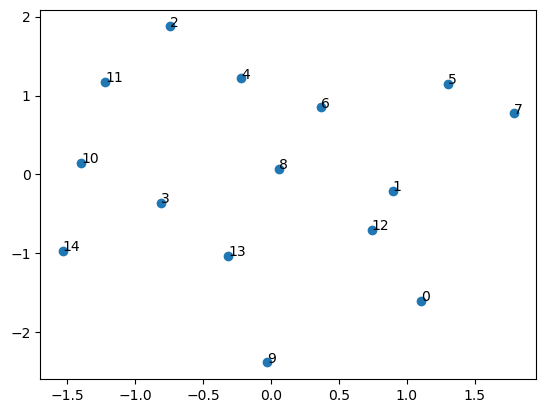

c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\tejas\Anaconda3\envs\eb\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


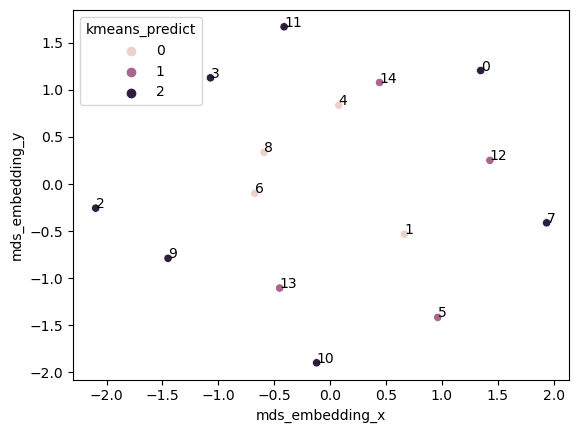

In [91]:
p_no = 30
pre_post = 0

mds = MDS(n_components=2, dissimilarity='precomputed')
mds_embedding = mds.fit_transform(similarity_matrix[p_no, pre_post])
# print(mds_embedding)

kmeans = KMeans(n_clusters=3)
kmeans.fit(similarity_matrix[p_no, pre_post])
kmeans_predictions = kmeans.predict(similarity_matrix[p_no, pre_post])

cluster_df = pd.DataFrame({'mds_embedding_x': mds_embedding[:, 0],
                           'mds_embedding_y': mds_embedding[:, 1], 
                           'kmeans_predict': kmeans_predictions})

g = sns.scatterplot(x = 'mds_embedding_x', y = 'mds_embedding_y', hue = 'kmeans_predict', data = cluster_df)
for i in range(15):
    g.annotate(i, mds_embedding[i])



In [21]:
clusters = {0:[0, 1, 2, 3, 4], 1:[5, 6, 7, 8, 9], 2:[10, 11, 12, 13, 14]}
def compute_cluster_sims(p_no, pre_post, similarity_matrix, clusters = clusters):
    within_cluster_sim = 0
    between_cluster_sim = 0

    for i, key in enumerate(clusters.keys()):
        within_cluster_indices = np.array(np.meshgrid(clusters[key], clusters[key])).T.reshape(-1, 2)
        within_cluster_sim += np.median(similarity_matrix[p_no, pre_post, key, within_cluster_indices])

        other_nodes = np.ravel(np.array([value for k, value in clusters.items() if k != key ]))
        between_cluster_indices = np.array(np.meshgrid(clusters[key], other_nodes)).T.reshape(-1, 2)

        between_cluster_sim += np.median(similarity_matrix[p_no, pre_post, key, between_cluster_indices])
    return between_cluster_sim/3, within_cluster_sim/3

In [17]:
cluster_sims = np.array([[compute_cluster_sims(p_no, pre_post, similarity_matrix=similarity_matrix) for pre_post in range(2)]
                for p_no in range(similarity_matrix.shape[0])
                ])

In [25]:
cluster_sims_df = pd.DataFrame({'participant' : np.repeat(np.arange(similarity_matrix.shape[0]), similarity_matrix.shape[1]*2),
                                'walk_length': np.repeat(walk_lengths, similarity_matrix.shape[1]*2),
                                'cluster_type' : np.tile(['between', 'within'], similarity_matrix.shape[1]*similarity_matrix.shape[0]),
                                'phase': np.tile(['pre', 'pre', 'post', 'post'], similarity_matrix.shape[0]),
                                'cluster_similarity': np.ravel(cluster_sims)
                                })

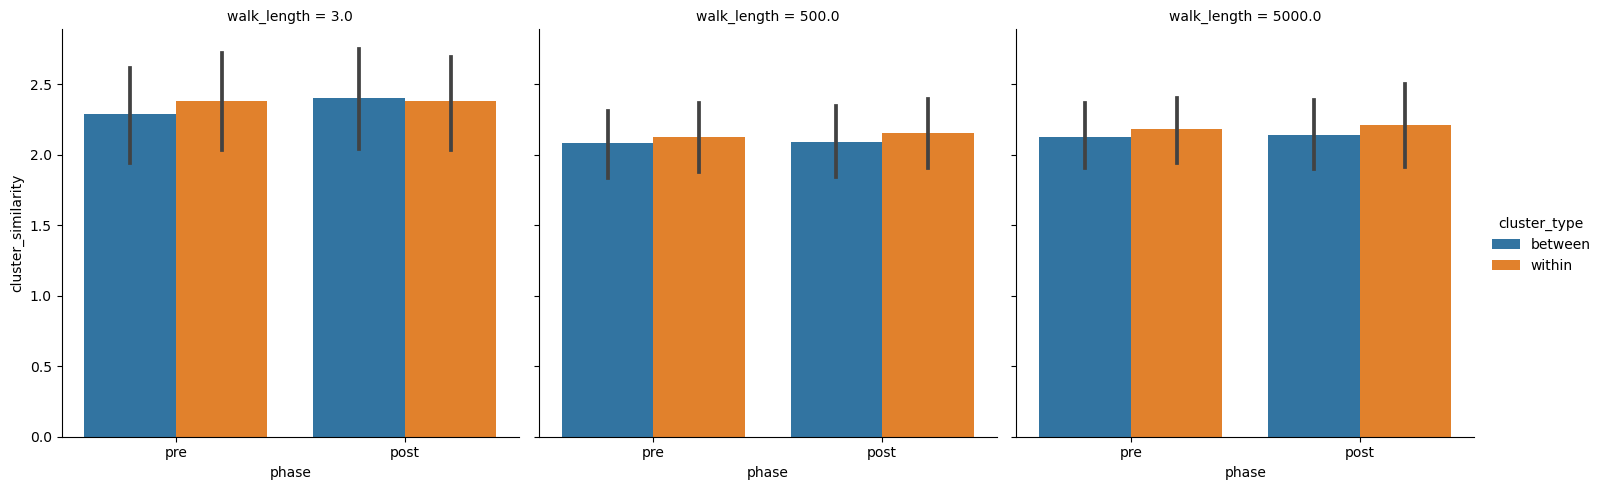

In [28]:
sns.catplot(y = 'cluster_similarity', col = 'walk_length', hue = 'cluster_type', x = 'phase', data = cluster_sims_df, kind = 'bar')

array([[12,  9],
       [ 0,  3],
       [ 2,  6],
       [ 3, 12],
       [12,  7],
       [10,  7],
       [ 2, 11],
       [ 8,  0],
       [11, 11],
       [ 7, 13],
       [14,  9],
       [ 6, 12],
       [10, 14],
       [ 7, 14],
       [11,  8],
       [ 0,  2],
       [ 9,  1],
       [ 6,  7],
       [14, 11],
       [ 9,  6],
       [ 4,  8],
       [10, 10],
       [ 5,  4],
       [10,  0],
       [ 7,  2],
       [ 0,  1],
       [ 7,  5],
       [10,  1],
       [ 6, 10],
       [ 2, 12],
       [ 0,  4],
       [10,  8],
       [ 2,  2],
       [ 6,  3],
       [ 5,  5],
       [ 2,  3],
       [ 7,  0],
       [ 9,  9],
       [14, 12],
       [ 8,  1],
       [11, 13],
       [ 3,  1],
       [10,  9],
       [ 6,  5],
       [ 5,  8],
       [10,  4],
       [ 9,  4],
       [ 3,  7],
       [ 8, 14],
       [ 1,  7],
       [ 1,  6],
       [ 9,  0],
       [14,  6],
       [10, 13],
       [10, 11],
       [ 4,  7],
       [ 4, 14],
       [14, 14],
       [ 3,  3